In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [5]:
# Settings
split_time = 3000
window_size = 60 # Number of slices to create from the time series
batch_size = 32
shuffle_buffer_size = 1000
forecast_period = 30 # For splitting data in many-to-many sequence model

In [6]:
# Helper functions
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_loss(history):
    loss=history.history['loss']
    epochs=range(len(loss)) # Get number of epochs
    plt.plot(epochs, loss, 'r')
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss"])

In [7]:
# https://www.kaggle.com/robervalt/sunspots
df = pd.read_csv('data/Sunspots.csv', usecols=['Date', 'Monthly Mean Total Sunspot Number'])

In [11]:
time = np.array(list(df.index))
sunspots = list(df['Monthly Mean Total Sunspot Number'])
series = np.array(sunspots)

time_train = time[:split_time]
train = series[:split_time]
time_test = time[split_time:]
test = series[split_time:]

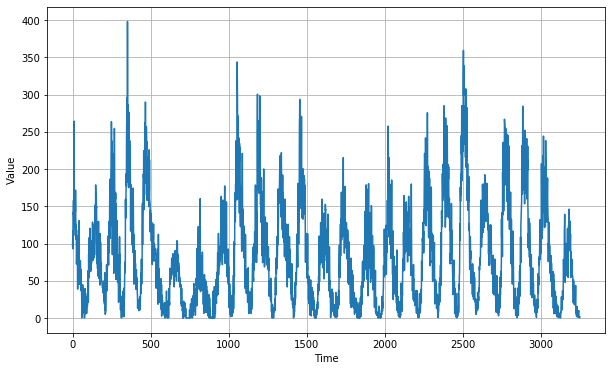

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

# Many-to-one Sequence Model

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """ Helper function that turns data into a window dataset"""
    series = tf.expand_dims(series, axis=-1) # Expand dimensions
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:-1], w[-1:])) # Data into features (x) and label (y)
    ds = ds.shuffle(shuffle_buffer) # shuffle_buffer = number of data items
    ds = ds.batch(batch_size).prefetch(1) # Batching the dataset into a groups of "batch_size"
    return ds

In [14]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Define Model

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(train, window_size=window_size,
                             batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model_many_to_one = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # None = Model can take sequences of any length
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100) # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
])

# Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
              optimizer=optimizer,
              metrics=["mae"])
model_many_to_one.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

### Train

In [16]:
history = model_many_to_one.fit(train_set,epochs=10)

Epoch 1/10
92/92 [==============================] - 7s 77ms/step - loss: 37.5908 - mae: 38.0897
Epoch 2/10
92/92 [==============================] - 4s 45ms/step - loss: 22.5052 - mae: 22.9985
Epoch 3/10
92/92 [==============================] - 4s 47ms/step - loss: 22.0136 - mae: 22.5014
Epoch 4/10
92/92 [==============================] - 4s 45ms/step - loss: 21.9739 - mae: 22.4727
Epoch 5/10
92/92 [==============================] - 4s 47ms/step - loss: 20.6810 - mae: 21.1796
Epoch 6/10
92/92 [==============================] - 4s 48ms/step - loss: 21.4477 - mae: 21.9404
Epoch 7/10
92/92 [==============================] - 4s 46ms/step - loss: 19.5140 - mae: 20.0075
Epoch 8/10
92/92 [==============================] - 4s 49ms/step - loss: 19.7502 - mae: 20.2382
Epoch 9/10
92/92 [==============================] - 4s 48ms/step - loss: 19.2528 - mae: 19.7495
Epoch 10/10
92/92 [==============================] - 4s 49ms/step - loss: 19.3807 - mae: 19.8680


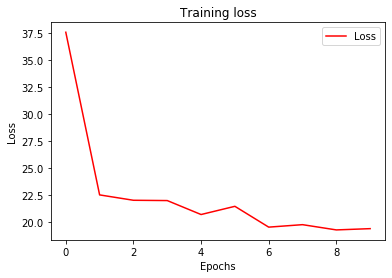

In [17]:
plot_loss(history)

### Test

In [18]:
forecast = model_forecast(model_many_to_one,
                          series[..., np.newaxis],
                          window_size, batch_size)[split_time - window_size + 1:, 0]

In [19]:
mae = tf.keras.metrics.mean_absolute_error(test, forecast).numpy()
mae

10.824526

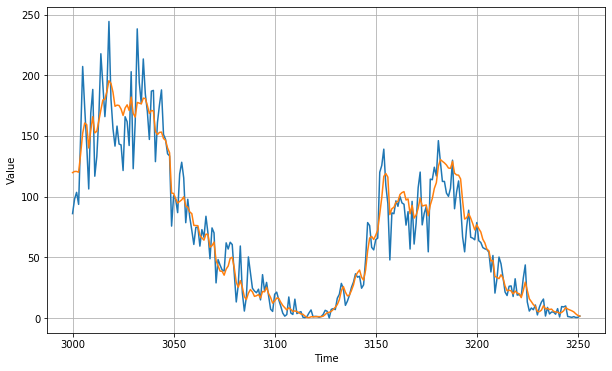

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_test, test)
plot_series(time_test, forecast)

# Many-to-many Sequence Model

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, forecast_period):
    """ Helper function that turns data into a window dataset"""
    series = tf.expand_dims(series, axis=-1) # Expand dimensions
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:-forecast_period], w[forecast_period:])) # Data into features (x) and label (y)
    ds = ds.shuffle(shuffle_buffer) # shuffle_buffer = number of data items
    ds = ds.batch(batch_size).prefetch(1) # Batching the dataset into a groups of "batch_size"
    return ds

In [16]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Define Model

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(train, window_size=window_size,
                             batch_size=batch_size, shuffle_buffer=shuffle_buffer_size,
                             forecast_period=forecast_period)
model_many_to_many = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]), # None = Model can take sequences of any length
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100) # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_many_to_many.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
              optimizer=optimizer,
              metrics=["mae"])
model_many_to_many.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

### Train

In [93]:
history = model_many_to_many.fit(train_set,epochs=500)

Epoch 1/500
92/92 [==============================] - 3s 29ms/step - loss: 33.5021 - mae: 33.9963
Epoch 2/500
92/92 [==============================] - 2s 27ms/step - loss: 33.1028 - mae: 33.6015
Epoch 3/500
92/92 [==============================] - 3s 30ms/step - loss: 34.1802 - mae: 34.6814
Epoch 4/500
92/92 [==============================] - 3s 32ms/step - loss: 32.6813 - mae: 33.1823
Epoch 5/500
92/92 [==============================] - 4s 39ms/step - loss: 32.6586 - mae: 33.1538
Epoch 6/500
92/92 [==============================] - 4s 42ms/step - loss: 32.6792 - mae: 33.1758
Epoch 7/500
92/92 [==============================] - 3s 28ms/step - loss: 31.8869 - mae: 32.3811
Epoch 8/500
92/92 [==============================] - 2s 27ms/step - loss: 31.7138 - mae: 32.2062
Epoch 9/500
92/92 [==============================] - 3s 33ms/step - loss: 31.6605 - mae: 32.1557
Epoch 10/500
92/92 [==============================] - 3s 32ms/step - loss: 32.1157 - mae: 32.6080
Epoch 11/500
92/92 [=========

Epoch 166/500
92/92 [==============================] - 3s 33ms/step - loss: 24.2127 - mae: 24.7040
Epoch 167/500
92/92 [==============================] - 3s 37ms/step - loss: 24.1126 - mae: 24.6043
Epoch 168/500
92/92 [==============================] - 3s 31ms/step - loss: 23.7602 - mae: 24.2530
Epoch 169/500
92/92 [==============================] - 3s 31ms/step - loss: 24.1511 - mae: 24.6383
Epoch 170/500
92/92 [==============================] - 3s 31ms/step - loss: 23.9571 - mae: 24.4463
Epoch 171/500
92/92 [==============================] - 3s 31ms/step - loss: 23.7016 - mae: 24.1979
Epoch 172/500
92/92 [==============================] - 3s 32ms/step - loss: 23.6826 - mae: 24.1684
Epoch 173/500
92/92 [==============================] - 3s 33ms/step - loss: 23.7737 - mae: 24.2705
Epoch 174/500
92/92 [==============================] - 3s 31ms/step - loss: 23.8844 - mae: 24.3773
Epoch 175/500
92/92 [==============================] - 3s 31ms/step - loss: 23.5980 - mae: 24.0901
Epoch 176/

92/92 [==============================] - 3s 29ms/step - loss: 20.7753 - mae: 21.2635
Epoch 331/500
92/92 [==============================] - 3s 31ms/step - loss: 20.7171 - mae: 21.2076
Epoch 332/500
92/92 [==============================] - 3s 30ms/step - loss: 20.5355 - mae: 21.0286
Epoch 333/500
92/92 [==============================] - 3s 28ms/step - loss: 20.7460 - mae: 21.2370
Epoch 334/500
92/92 [==============================] - 3s 29ms/step - loss: 20.6972 - mae: 21.1876
Epoch 335/500
92/92 [==============================] - 3s 34ms/step - loss: 20.6842 - mae: 21.1710
Epoch 336/500
92/92 [==============================] - 3s 32ms/step - loss: 20.6204 - mae: 21.1099
Epoch 337/500
92/92 [==============================] - 3s 32ms/step - loss: 20.4782 - mae: 20.9683
Epoch 338/500
92/92 [==============================] - 3s 32ms/step - loss: 20.6233 - mae: 21.1096
Epoch 339/500
92/92 [==============================] - 3s 34ms/step - loss: 20.4834 - mae: 20.9750
Epoch 340/500
92/92 [===

92/92 [==============================] - 3s 32ms/step - loss: 18.2327 - mae: 18.7176
Epoch 495/500
92/92 [==============================] - 3s 30ms/step - loss: 18.6241 - mae: 19.1121
Epoch 496/500
92/92 [==============================] - 3s 27ms/step - loss: 18.3282 - mae: 18.8178
Epoch 497/500
92/92 [==============================] - 2s 27ms/step - loss: 18.1359 - mae: 18.6240
Epoch 498/500
92/92 [==============================] - 3s 27ms/step - loss: 18.2148 - mae: 18.6993
Epoch 499/500
92/92 [==============================] - 3s 28ms/step - loss: 18.3902 - mae: 18.8790
Epoch 500/500
92/92 [==============================] - 3s 28ms/step - loss: 18.3009 - mae: 18.7903


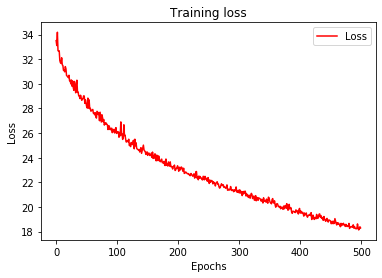

In [94]:
plot_loss(history)

### Test

In [106]:
# Using the past 30 values as inputs and predicting the next 30 values,
# iterate to get forecast for the entire test set

num_batch = 7
time_test_subset = np.array([])
test_subset = np.array([])
forecast_subset = np.array([])

for i in range(num_batch):
    if i == 0:
        time_test_chunk = time_test[-30:] # last 30 test timestep
        test_chunk = test[-30:] # last 30 test values
        series_chunk = test[-60:-30] # last 60 to last 30 as x values
        series_chunk = series_chunk.reshape(1, len(series_chunk), 1) # Reshape to 3D array for CNN
        forecast_chunk = model_many_to_many.predict(series_chunk).ravel()

        # Append chunks
        time_test_subset = np.append(time_test_chunk, time_test_subset)
        test_subset = np.append(test_chunk, test_subset)
        forecast_subset = np.append(forecast_chunk, forecast_subset)
    else:
        t1 = -30 * i
        t2 = -30 * (i + 1) 
        t3 = -30 * (i + 2)
        time_test_chunk = time_test[t2:t1]
        test_chunk = test[t2:t1]
        series_chunk = test[t3:t2]
        series_chunk = series_chunk.reshape(1, len(series_chunk), 1) # Reshape to 3D array for CNN
        forecast_chunk = model_many_to_many.predict(series_chunk).ravel()

        # Append chunks
        time_test_subset = np.append(time_test_chunk, time_test_subset)
        test_subset = np.append(test_chunk, test_subset)
        forecast_subset = np.append(forecast_chunk, forecast_subset)  
        

In [109]:
mae = tf.keras.metrics.mean_absolute_error(test_subset, forecast_subset).numpy()
mae

37.16862102644783

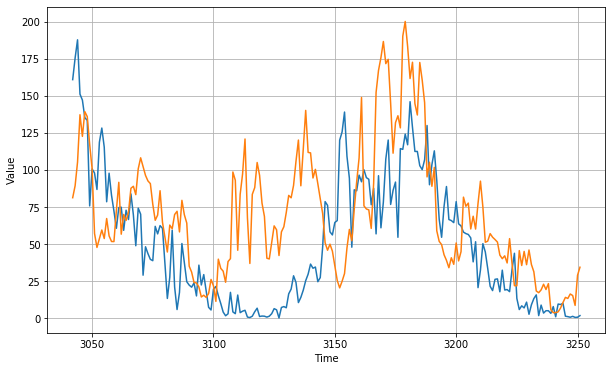

In [107]:
plt.figure(figsize=(10, 6))
plot_series(time_test_subset, test_subset)
plot_series(time_test_subset, forecast_subset)